Попробуем реализовать ASSP сеть для задачи семантической сегментации. В качестве датасета будем использовать COCOdataset

In [ ]:
!mkdir -p data

!cd data && wget http://images.cocodataset.org/zips/train2017.zip 
!cd data && wget http://images.cocodataset.org/zips/val2017.zip 
!cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 
  
!cd data && unzip -q train2017.zip
!cd data && unzip -q val2017.zip
!cd data && unzip -q annotations_trainval2017.zip

!cd data && git clone https://github.com/cocodataset/cocoapi
!cd data/cocoapi/PythonAPI && make

--2022-06-25 10:58:08--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.202.193
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.202.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  80.5MB/s    in 4m 15s  

2022-06-25 11:02:24 (72.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2022-06-25 11:02:24--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.166.177
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.166.177|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  92.1MB/s    in 9.1s    

2022-06-25 11:02:33 (85.9 MB/s) 

# Загрузка библиотек

In [ ]:
!pip install mxnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.8 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import os
import skimage.io as io
import numpy as np
from mxnet import image
import matplotlib.pyplot as plt

from pathlib import Path
import datetime
import imageio

import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.2


## COCO Api

In [ ]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

In [ ]:
from os import listdir
from os.path import isfile, join

## Фуннкции создания датасетов

In [ ]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)], # задаем размер паддинга
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)# создаем паддинги для изображения

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2])) # случайным образом обрезает изображение
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            # py_function оборачивает функцию питон в тензорфлоу
            img_combined = tf.py_function(self.read_images, [item], tf.uint8) # read_images реализован ниже
            img_combined = self.crop_images(img_combined, inp_size, random_crop) # обрезать

            # тут приводим значения в слоях к флоату и нормализуем
            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)

            # без строчки ниже не работало, так как сеть не принимала неявное (None) задание количества каналов
            img = tf.reshape(img,[256,256,3])
            # тут приводим значения слоя маски к флоату
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        # repeat выводит весь датасет столько сколько эпох
        # dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True) #drop_remainder пакеты одинакового размера

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

Класс, наследованный от нашего класса `Dataset`, в котром реализован метод `read_images`, специфичный для датасета COCO

In [ ]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)
        # Загружается не весь сет, а 4000
        # temp_img_list = self.coco.getImgIds(catIds=self.cat_ids)
        # self.img_list = []
        # for img_id in temp_img_list:
        #   if len(self.img_list) < 15000:
        #     img_data = self.coco.loadImgs(img_id)[0]
        #     img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])
        #     if os.path.isfile(os.path.join(COCO_ROOT, img_fname)):
        #       self.img_list.append(img_id)
        #   else:
        #     break

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))


        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

## Тренировочный и валидационный датасеты

In [ ]:
# Тут надо бы поправить, эпохи для формирования датасета нам не нужны.

batch_size = 32
epochs = 5
inp_size = 256

In [ ]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

train_ds = COCO_dataset_train.train_dataset(batch_size=batch_size, epochs=epochs, inp_size=inp_size)
val_ds = COCO_dataset_val.val_dataset(batch_size=batch_size, inp_size=inp_size)

loading annotations into memory...
Done (t=15.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


**Посмотрим на датасет**

In [ ]:
count=0
for img, mask in train_ds:

  count+=1
  if count==7:
      break

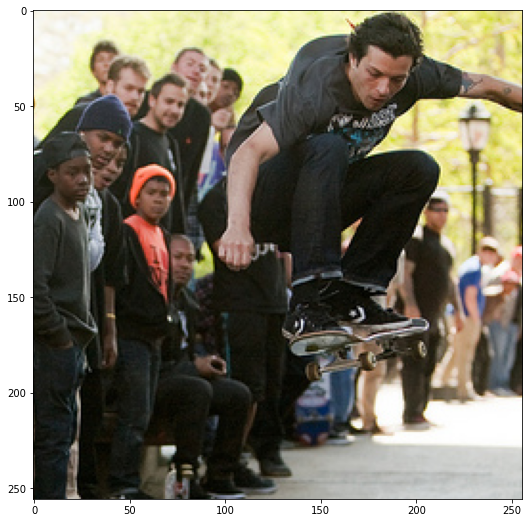

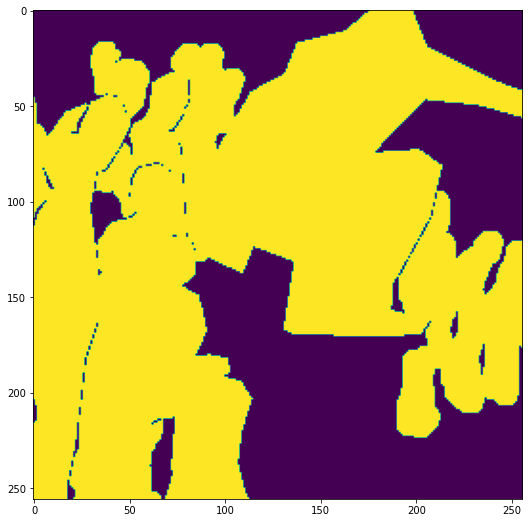

In [ ]:
plt.figure(figsize=[9, 9]); _=plt.imshow(img[0, ...])
plt.figure(figsize=[9, 9]); _=plt.imshow(mask[0, ...][...,0])

# Модели

## ASPP

Построим ASPP-сеть, используем также батч-нормализацию. Такая модель принимает на вход изображение любого размера

In [ ]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [ ]:
# Construct and compile an instance of CustomModel

conv_params = {
            'padding': 'same',
            'activation' : 'relu'
        }


inputs = tf.keras.Input(shape=(None,None,3))

out = tf.keras.layers.Conv2D(64, (3,3), use_bias=False, **conv_params)(inputs)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(64, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.MaxPooling2D((2,2),(2,2), padding='same')(out)

out = tf.keras.layers.Conv2D(128, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(128, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.MaxPooling2D((2,2),(2,2), padding='same')(out)

out = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out_enc_mid = out

out = tf.keras.layers.MaxPooling2D((2,2),(2,2), padding='same')(out)

out = tf.keras.layers.Conv2D(512, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(512, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.MaxPooling2D((2,2),(2,2), padding='same')(out)

out = tf.keras.layers.Conv2D(512, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(512, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)
# ASPP
out1 = tf.keras.layers.Conv2D(256, (1,1), use_bias=False, **conv_params)(out)
out2 = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, dilation_rate=6,**conv_params)(out)
out3 = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, dilation_rate=12,**conv_params)(out)
out4 = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, dilation_rate=18,**conv_params)(out)
out = tf.keras.layers.Concatenate(axis=3)([out1, out2, out3, out4])
out = tf.keras.layers.Conv2D(256, (1,1), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

# out = tf.keras.layers.Resizing(tf.shape(out_enc_mid)[0],tf.shape(out_enc_mid)[1],interpolation='bilinear')(out)

out = tf.image.resize(out, tf.shape(out_enc_mid)[1:3], tf.image.ResizeMethod.BILINEAR)


out_enc_mid = tf.keras.layers.Conv2D(48, (1,1), use_bias=False, **conv_params)(out_enc_mid)
out_enc_mid = tf.keras.layers.BatchNormalization(axis=-1)(out_enc_mid)
out = tf.nn.relu(out_enc_mid)


out = tf.keras.layers.Concatenate(axis=3)([out, out_enc_mid])

out = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(256, (3,3), use_bias=False, **conv_params)(out)
out = tf.keras.layers.BatchNormalization(axis=-1)(out)
out = tf.nn.relu(out)

out = tf.keras.layers.Conv2D(1, (1,1), use_bias=False, activation=None, padding='same')(out)


outputs = tf.image.resize(out, tf.shape(inputs)[1:3], tf.image.ResizeMethod.BILINEAR)


In [ ]:
def loss(logits, labels):
    return tf.losses.sigmoid_cross_entropy(labels, logits)

In [ ]:
model = CustomModel(inputs, outputs)
# loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              # metrics=['accuracy']
              )

In [ ]:
model.fit(train_ds, batch_size=batch_size, validation_data=val_ds,epochs=4)

Epoch 1/4
2003/2003 [==============================] - 2157s 1s/step - loss: 0.3950 - val_loss: 0.5168
Epoch 2/4
2003/2003 [==============================] - 2141s 1s/step - loss: 0.3449 - val_loss: 0.4104
Epoch 3/4
2003/2003 [==============================] - 2141s 1s/step - loss: 0.3187 - val_loss: 0.3504
Epoch 4/4
2003/2003 [==============================] - 2142s 1s/step - loss: 0.3037 - val_loss: 0.3309


**Посмотрим, как работает**



In [ ]:
img = imageio.imread('/content/jk.jpg')
img = img[None, ...].astype(np.float32) / np.float32(255.)
logits = model.predict(img)
img_out = tf.sigmoid(logits).numpy()
img_out = np.round(img_out[0, ...])


In [ ]:
img_out = tf.sigmoid(logits).numpy()
img_out = np.round(img_out[0, ...])

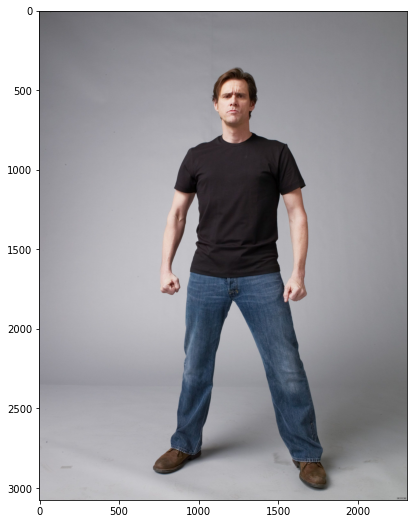

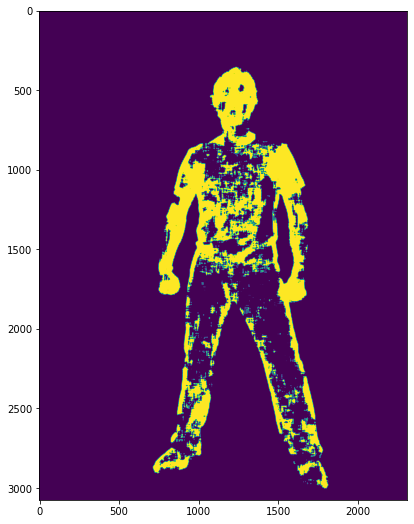

In [ ]:
plt.figure(figsize=[9, 9]); _=plt.imshow(img[0, ...])
plt.figure(figsize=[9, 9]); _=plt.imshow(img_out[..., 0])

Довольно неплохо.
Судя по логам, есть потенциал для улучшения работы модели, но нет ресурсов.
Надо попробовать U-net.